In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
from scipy.stats import binned_statistic_2d
from sklearn.preprocessing import StandardScaler
import re

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import PReLU

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.losses import Huber
from tensorflow.keras.activations import swish

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

from scipy.spatial import Voronoi, voronoi_plot_2d
import time
import math
from scipy.spatial import cKDTree

from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LeakyReLU

from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

import torch
import traceback
import shap

import pickle
import seaborn as sns

In [90]:
bestDiffCrownStatsHistory = pd.read_csv("/kaggle/input/bestdiffcrownneighbourstats/funnelElu_MedStat_crown_diff_msemaxEpoch256relativeErrorCrown_73.18percHistory.csv")
bestDiffHeightStatsHistory = pd.read_csv("/kaggle/input/bestdiffneighbourstats/funnelPrelu_MedStat_height_diff_msemaxEpoch256relativeErrorHeight_10.4percHistory.csv")

bestCrownStatsHistory = pd.read_csv("/kaggle/input/bestrelerrcrownneighbours/funnelPrelu_MedStat_crown_relErrmaxEpoch256relativeErrorCrown_51.76percHistory.csv")
bestHeightStatsHistory = pd.read_csv("/kaggle/input/bestrelerrmethod/funnelPrelu_MedStat_height_relErrmaxEpoch256relativeErrorHeight_10.25percHistory.csv")

bestKNNCrownRelErrHistory = pd.read_csv("/kaggle/input/bestknncrownrelativeerr/bottleElu_5NN_crown_relErrmaxEpoch256relativeErrorCrown_51.74percHistory.csv")
bestKNNheightRelErrHistory = pd.read_csv("/kaggle/input/bestknnheightrelerr/bottleMish_5NN_height_relErrmaxEpoch256relativeErrorHeight_10.75percHistory.csv")

bestKNNDiffCrownMSEHistory = pd.read_csv("/kaggle/input/bestknncrownmse/brickElu_height_diff_msemaxEpoch256relativeErrorCrown_73.56percHistory.csv")
bestKNNDiffHeightMSEHistory = pd.read_csv("/kaggle/input/bestknnheightmse/funnelElu_height_diff_msemaxEpoch256relativeErrorHeight_10.81percHistory.csv")

print("bestDiffCrownStatsHistory:", bestDiffCrownStatsHistory.columns.tolist())
print("bestDiffHeightStatsHistory:", bestDiffHeightStatsHistory.columns.tolist())
print("bestCrownStatsHistory:", bestCrownStatsHistory.columns.tolist())
print("bestHeightStatsHistory:", bestHeightStatsHistory.columns.tolist())
print("bestKNNCrownRelErrHistory:", bestKNNCrownRelErrHistory.columns.tolist())
print("bestKNNheightRelErrHistory:", bestKNNheightRelErrHistory.columns.tolist())
print("bestKNNDiffCrownMSEHistory:", bestKNNDiffCrownMSEHistory.columns.tolist())
print("bestKNNDiffHeightMSEHistory:", bestKNNDiffHeightMSEHistory.columns.tolist())

bestDiffCrownStatsHistory: ['loss', 'val_loss', 'learning_rate']
bestDiffHeightStatsHistory: ['loss', 'val_loss', 'learning_rate']
bestCrownStatsHistory: ['loss', 'val_loss', 'learning_rate']
bestHeightStatsHistory: ['loss', 'val_loss', 'learning_rate']
bestKNNCrownRelErrHistory: ['loss', 'val_loss', 'learning_rate']
bestKNNheightRelErrHistory: ['loss', 'val_loss', 'learning_rate']
bestKNNDiffCrownMSEHistory: ['loss', 'val_loss', 'learning_rate']
bestKNNDiffHeightMSEHistory: ['loss', 'val_loss', 'learning_rate']


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


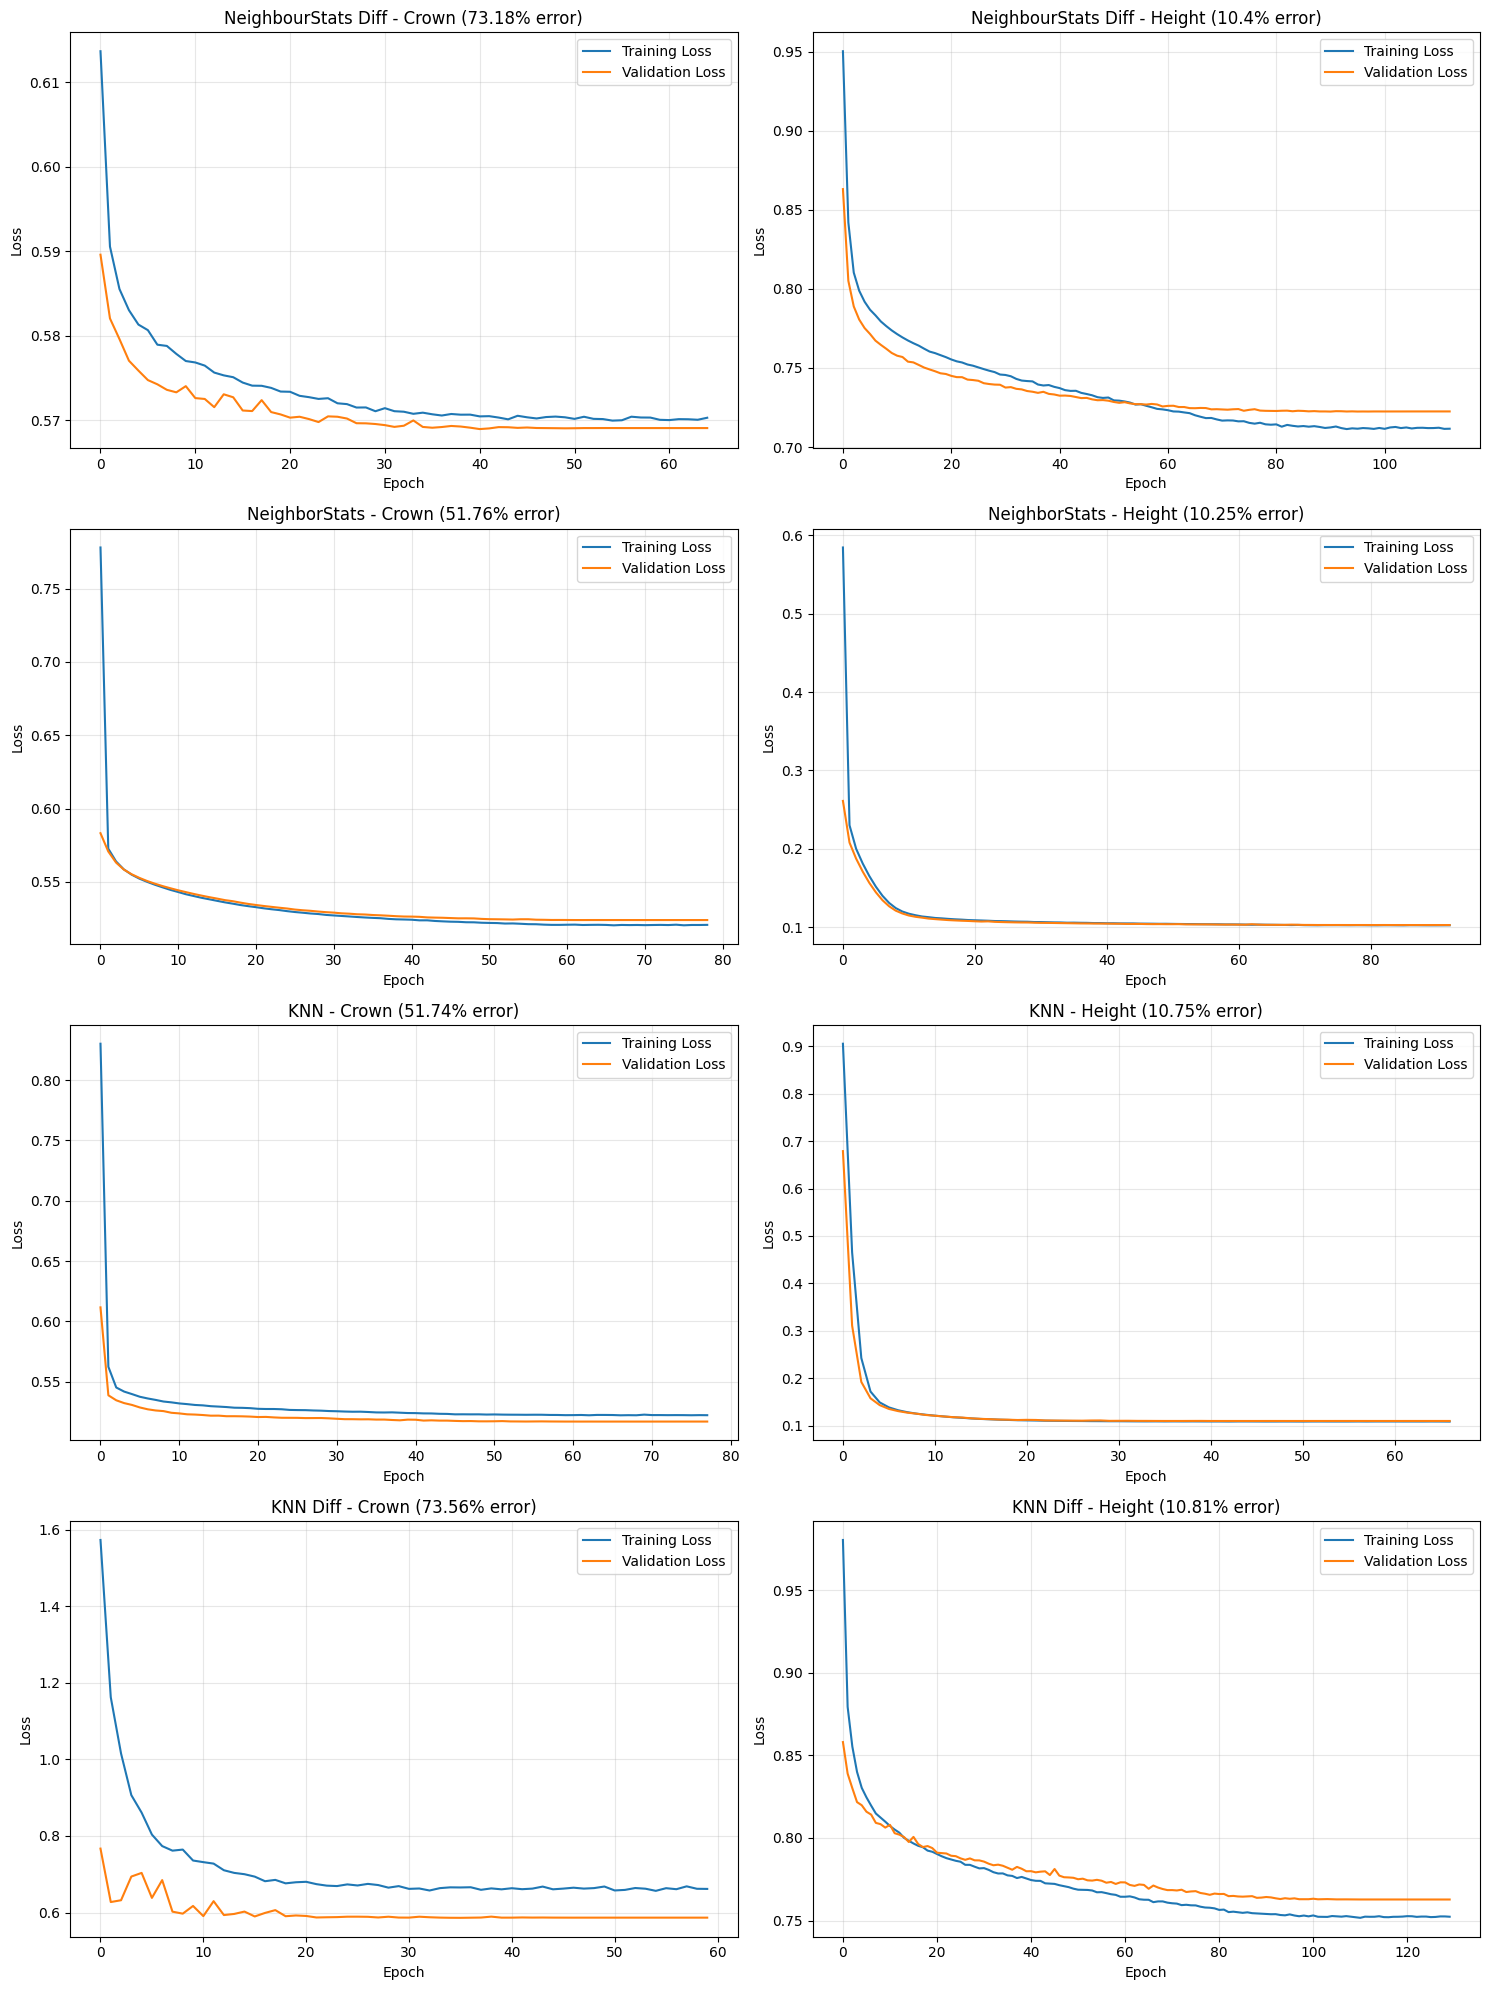

In [95]:


# Set up the figure
plt.figure(figsize=(15, 20))

# List all history DataFrames with their titles
models = [
    (bestDiffCrownStatsHistory, "NeighbourStats Diff - Crown (73.18% error)"),
    (bestDiffHeightStatsHistory, "NeighbourStats Diff - Height (10.4% error)"),
    (bestCrownStatsHistory, "NeighborStats - Crown (51.76% error)"),
    (bestHeightStatsHistory, "NeighborStats - Height (10.25% error)"),
    (bestKNNCrownRelErrHistory, "KNN - Crown (51.74% error)"),
    (bestKNNheightRelErrHistory, "KNN - Height (10.75% error)"),
    (bestKNNDiffCrownMSEHistory, "KNN Diff - Crown (73.56% error)"),
    (bestKNNDiffHeightMSEHistory, "KNN Diff - Height (10.81% error)")
]

# Plot each model's loss curves
for i, (history, title) in enumerate(models, 1):
    plt.subplot(4, 2, i)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
bestDiffCrownStats = pd.read_csv("/kaggle/input/bestdiffcrownneighbourstats/funnelElu_MedStat_crown_diff_msemaxEpoch256relativeErrorCrown_73.18perc.csv")
bestDiffHeightStats = pd.read_csv("/kaggle/input/bestdiffneighbourstats/funnelPrelu_MedStat_height_diff_msemaxEpoch256relativeErrorHeight_10.4perc.csv")

bestCrownStats = pd.read_csv("/kaggle/input/bestrelerrcrownneighbours/funnelPrelu_MedStat_crown_relErrmaxEpoch256relativeErrorCrown_51.76perc.csv")
bestHeightStats = pd.read_csv("/kaggle/input/bestrelerrmethod/funnelPrelu_MedStat_height_relErrmaxEpoch256relativeErrorHeight_10.25perc.csv")

bestKNNCrownRelErr = pd.read_csv("/kaggle/input/bestknncrownrelativeerr/bottleElu_5NN_crown_relErrmaxEpoch256relativeErrorCrown_51.74perc.csv")
bestKNNheightRelErr = pd.read_csv("/kaggle/input/bestknnheightrelerr/bottleMish_5NN_height_relErrmaxEpoch256relativeErrorHeight_10.75perc.csv")


#NEW ADDITIONS
bestKNNDiffCrownMSE = pd.read_csv("/kaggle/input/bestknncrownmse/brickElu_height_diff_msemaxEpoch256relativeErrorCrown_73.56perc.csv")
bestKNNDiffHeightMSE = pd.read_csv("/kaggle/input/bestknnheightmse/funnelElu_height_diff_msemaxEpoch256relativeErrorHeight_10.81perc.csv")




In [79]:
print(bestDiffCrownStats.columns)
print(bestDiffHeightStats.columns)
print(bestKNNCrownRelErr.columns)
print(bestKNNheightRelErr.columns)
print(bestCrownStats.columns)
print(bestHeightStats.columns)

Index(['x', 'y', 'CrownAreaError', 'PredictedArea', 'TrueArea'], dtype='object')
Index(['x', 'y', 'HeightError', 'PredictedHeight', 'TrueHeight'], dtype='object')
Index(['x', 'y', 'CrownAreaError', 'PredictedArea', 'TrueArea'], dtype='object')
Index(['x', 'y', 'HeightError', 'PredictedHeight', 'TrueHeight'], dtype='object')
Index(['x', 'y', 'CrownAreaError', 'PredictedArea', 'TrueArea'], dtype='object')
Index(['x', 'y', 'HeightError', 'PredictedHeight', 'TrueHeight'], dtype='object')


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


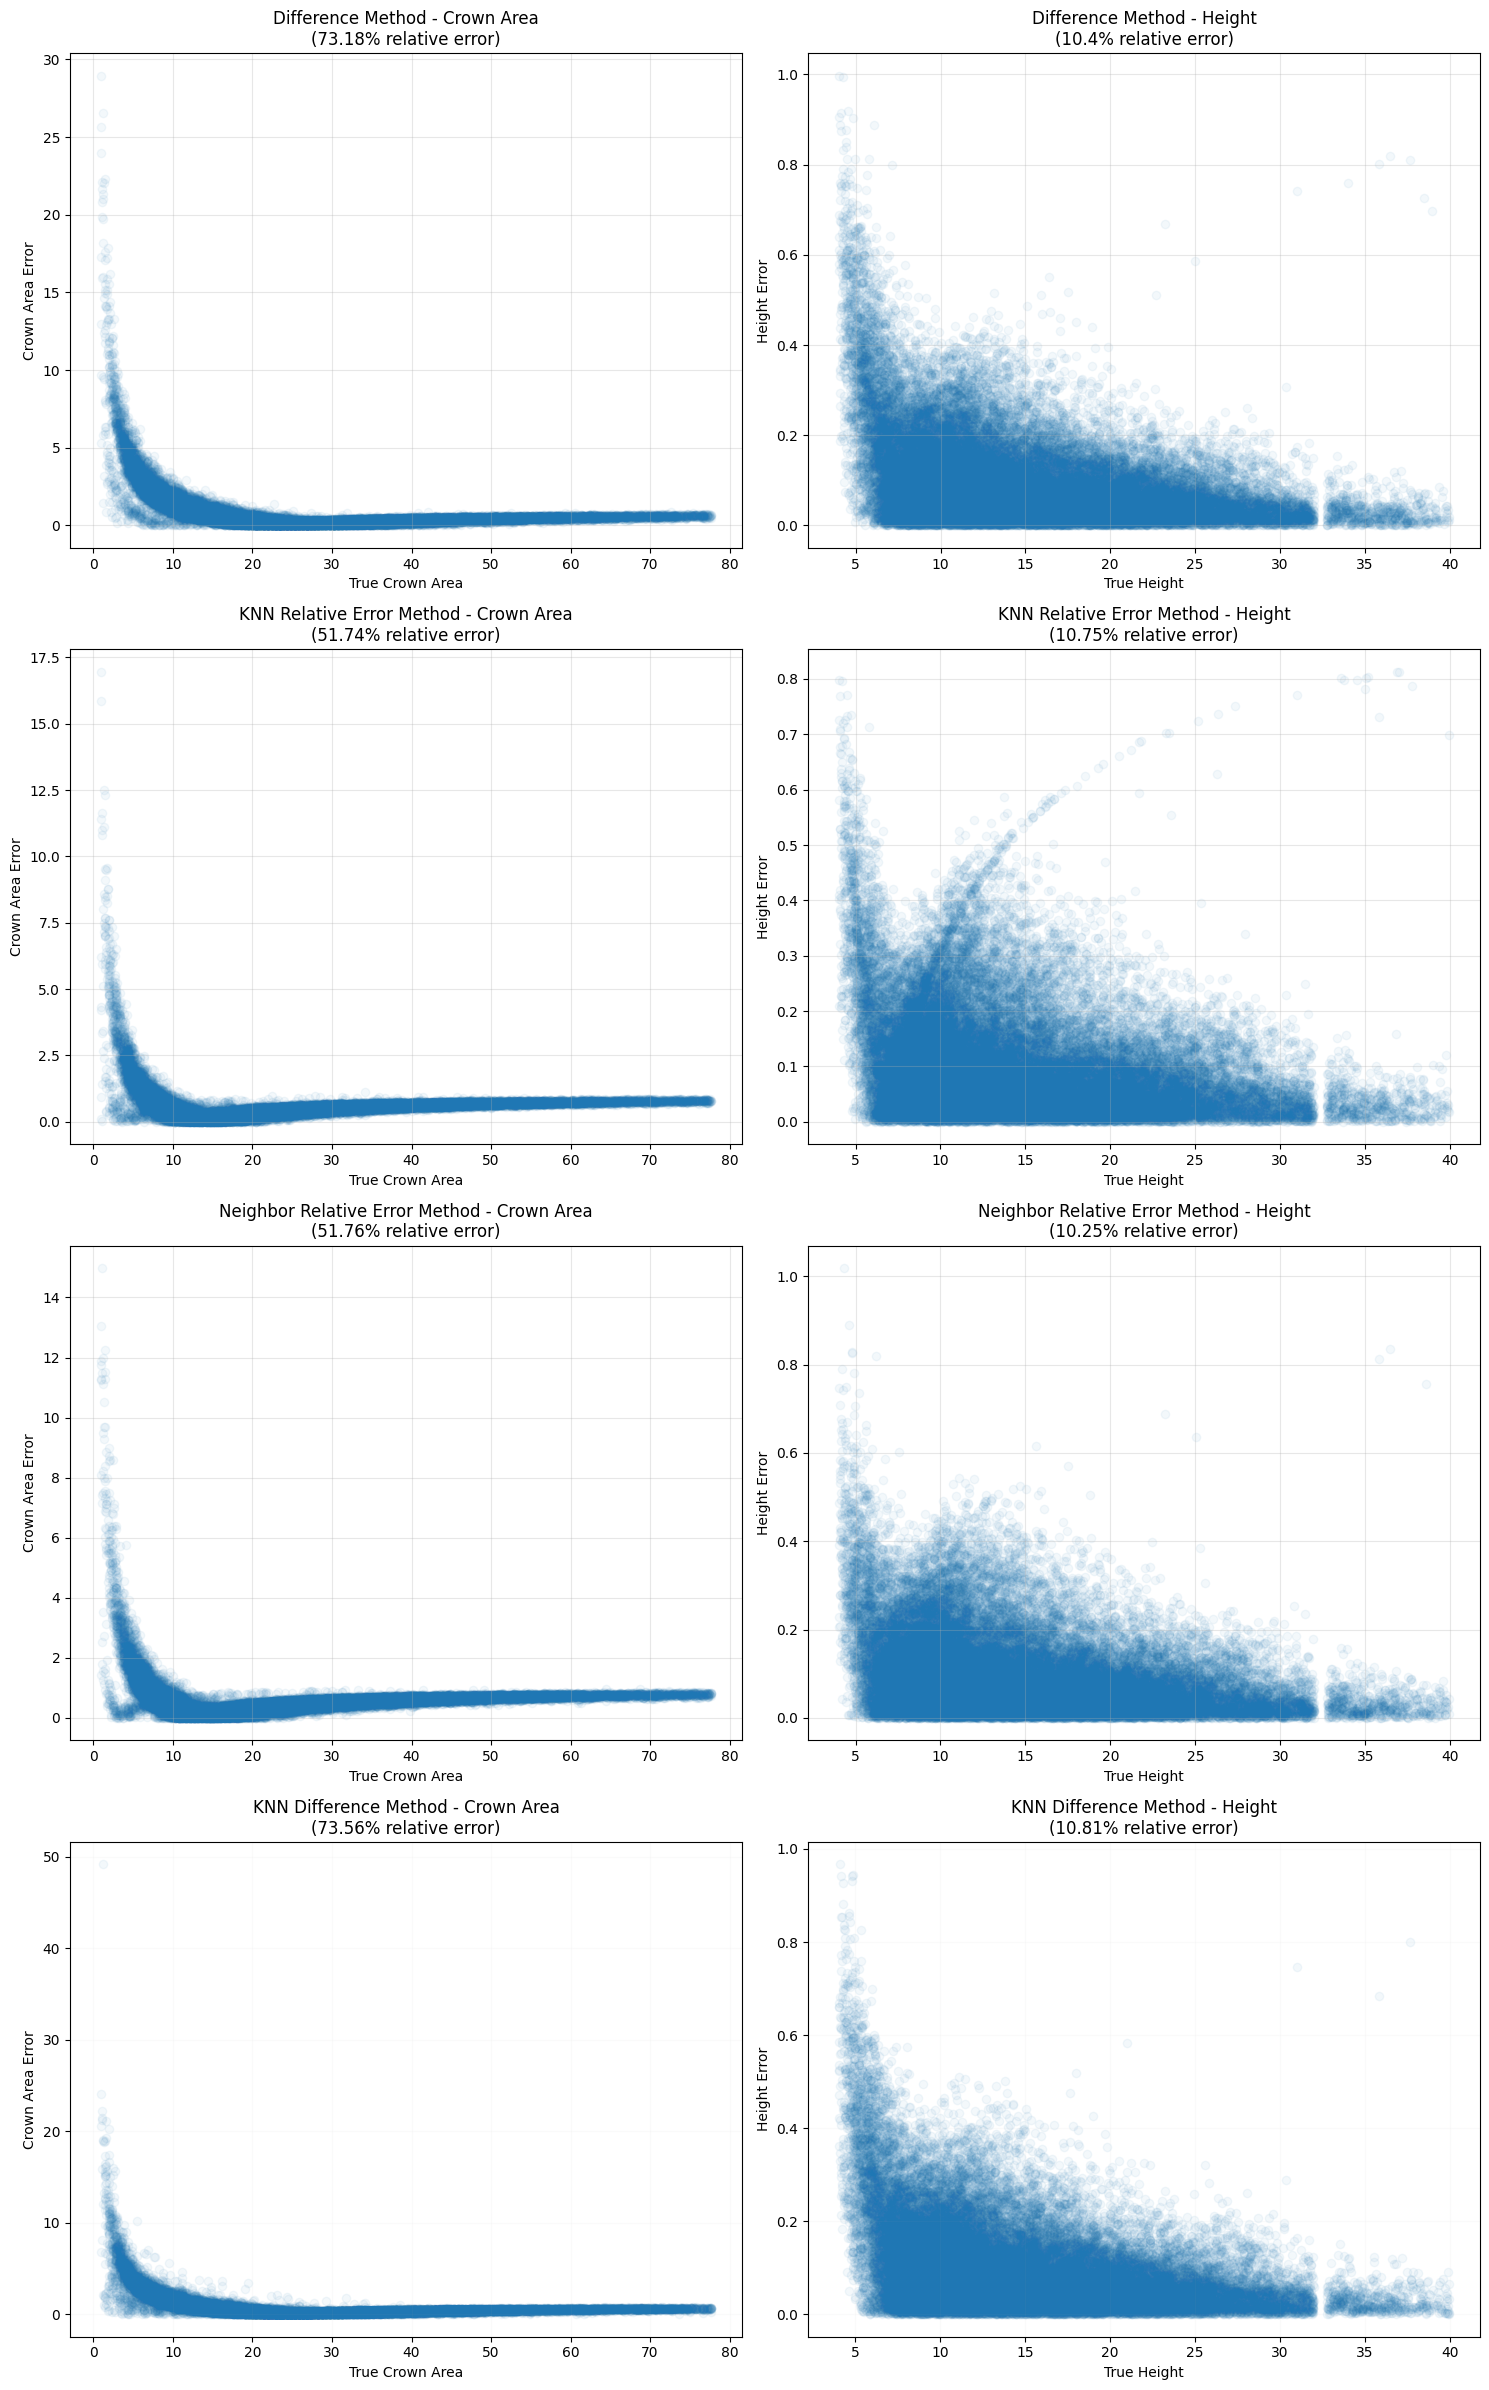

In [80]:
import matplotlib.pyplot as plt

# Set up the figure with 4 rows and 2 columns
plt.figure(figsize=(15, 24))

# 1. bestDiffCrownStats - Crown Area
plt.subplot(4, 2, 1)
plt.scatter(bestDiffCrownStats['TrueArea'], bestDiffCrownStats['CrownAreaError'], alpha=0.05)
plt.xlabel('True Crown Area')
plt.ylabel('Crown Area Error')
plt.title('Difference Method - Crown Area\n(73.18% relative error)')
plt.grid(True, alpha=0.3)

# 2. bestDiffHeightStats - Height
plt.subplot(4, 2, 2)
plt.scatter(bestDiffHeightStats['TrueHeight'], bestDiffHeightStats['HeightError'], alpha=0.05)
plt.xlabel('True Height')
plt.ylabel('Height Error')
plt.title('Difference Method - Height\n(10.4% relative error)')
plt.grid(True, alpha=0.3)

# 3. bestKNNCrownRelErr - Crown Area
plt.subplot(4, 2, 3)
plt.scatter(bestKNNCrownRelErr['TrueArea'], bestKNNCrownRelErr['CrownAreaError'], alpha=0.05)
plt.xlabel('True Crown Area')
plt.ylabel('Crown Area Error')
plt.title('KNN Direct Method - Crown Area\n(51.74% relative error)')
plt.grid(True, alpha=0.3)

# 4. bestKNNheightRelErr - Height
plt.subplot(4, 2, 4)
plt.scatter(bestKNNheightRelErr['TrueHeight'], bestKNNheightRelErr['HeightError'], alpha=0.05)
plt.xlabel('True Height')
plt.ylabel('Height Error')
plt.title('KNN Direct Method - Height\n(10.75% relative error)')
plt.grid(True, alpha=0.3)

# 5. bestCrownStats - Crown Area
plt.subplot(4, 2, 5)
plt.scatter(bestCrownStats['TrueArea'], bestCrownStats['CrownAreaError'], alpha=0.05)
plt.xlabel('True Crown Area')
plt.ylabel('Crown Area Error')
plt.title('Neighbor Direct Method - Crown Area\n(51.76% relative error)')
plt.grid(True, alpha=0.3)

# 6. bestHeightStats - Height
plt.subplot(4, 2, 6)
plt.scatter(bestHeightStats['TrueHeight'], bestHeightStats['HeightError'], alpha=0.05)
plt.xlabel('True Height')
plt.ylabel('Height Error')
plt.title('Neighbor Direct Method - Height\n(10.25% relative error)')
plt.grid(True, alpha=0.3)

# 7. bestKNNDiffCrownMSE - Crown Area
plt.subplot(4, 2, 7)
plt.scatter(bestKNNDiffCrownMSE['TrueArea'], bestKNNDiffCrownMSE['CrownAreaError'], alpha=0.05)
plt.xlabel('True Crown Area')
plt.ylabel('Crown Area Error')
plt.title('KNN Difference Method - Crown Area\n(73.56% relative error)')
plt.grid(True, alpha=0.05)

# 8. bestKNNDiffHeightMSE - Height
plt.subplot(4, 2, 8)
plt.scatter(bestKNNDiffHeightMSE['TrueHeight'], bestKNNDiffHeightMSE['HeightError'], alpha=0.05)
plt.xlabel('True Height')
plt.ylabel('Height Error')
plt.title('KNN Difference Method - Height\n(10.81% relative error)')
plt.grid(True, alpha=0.05)

plt.tight_layout()
plt.show()

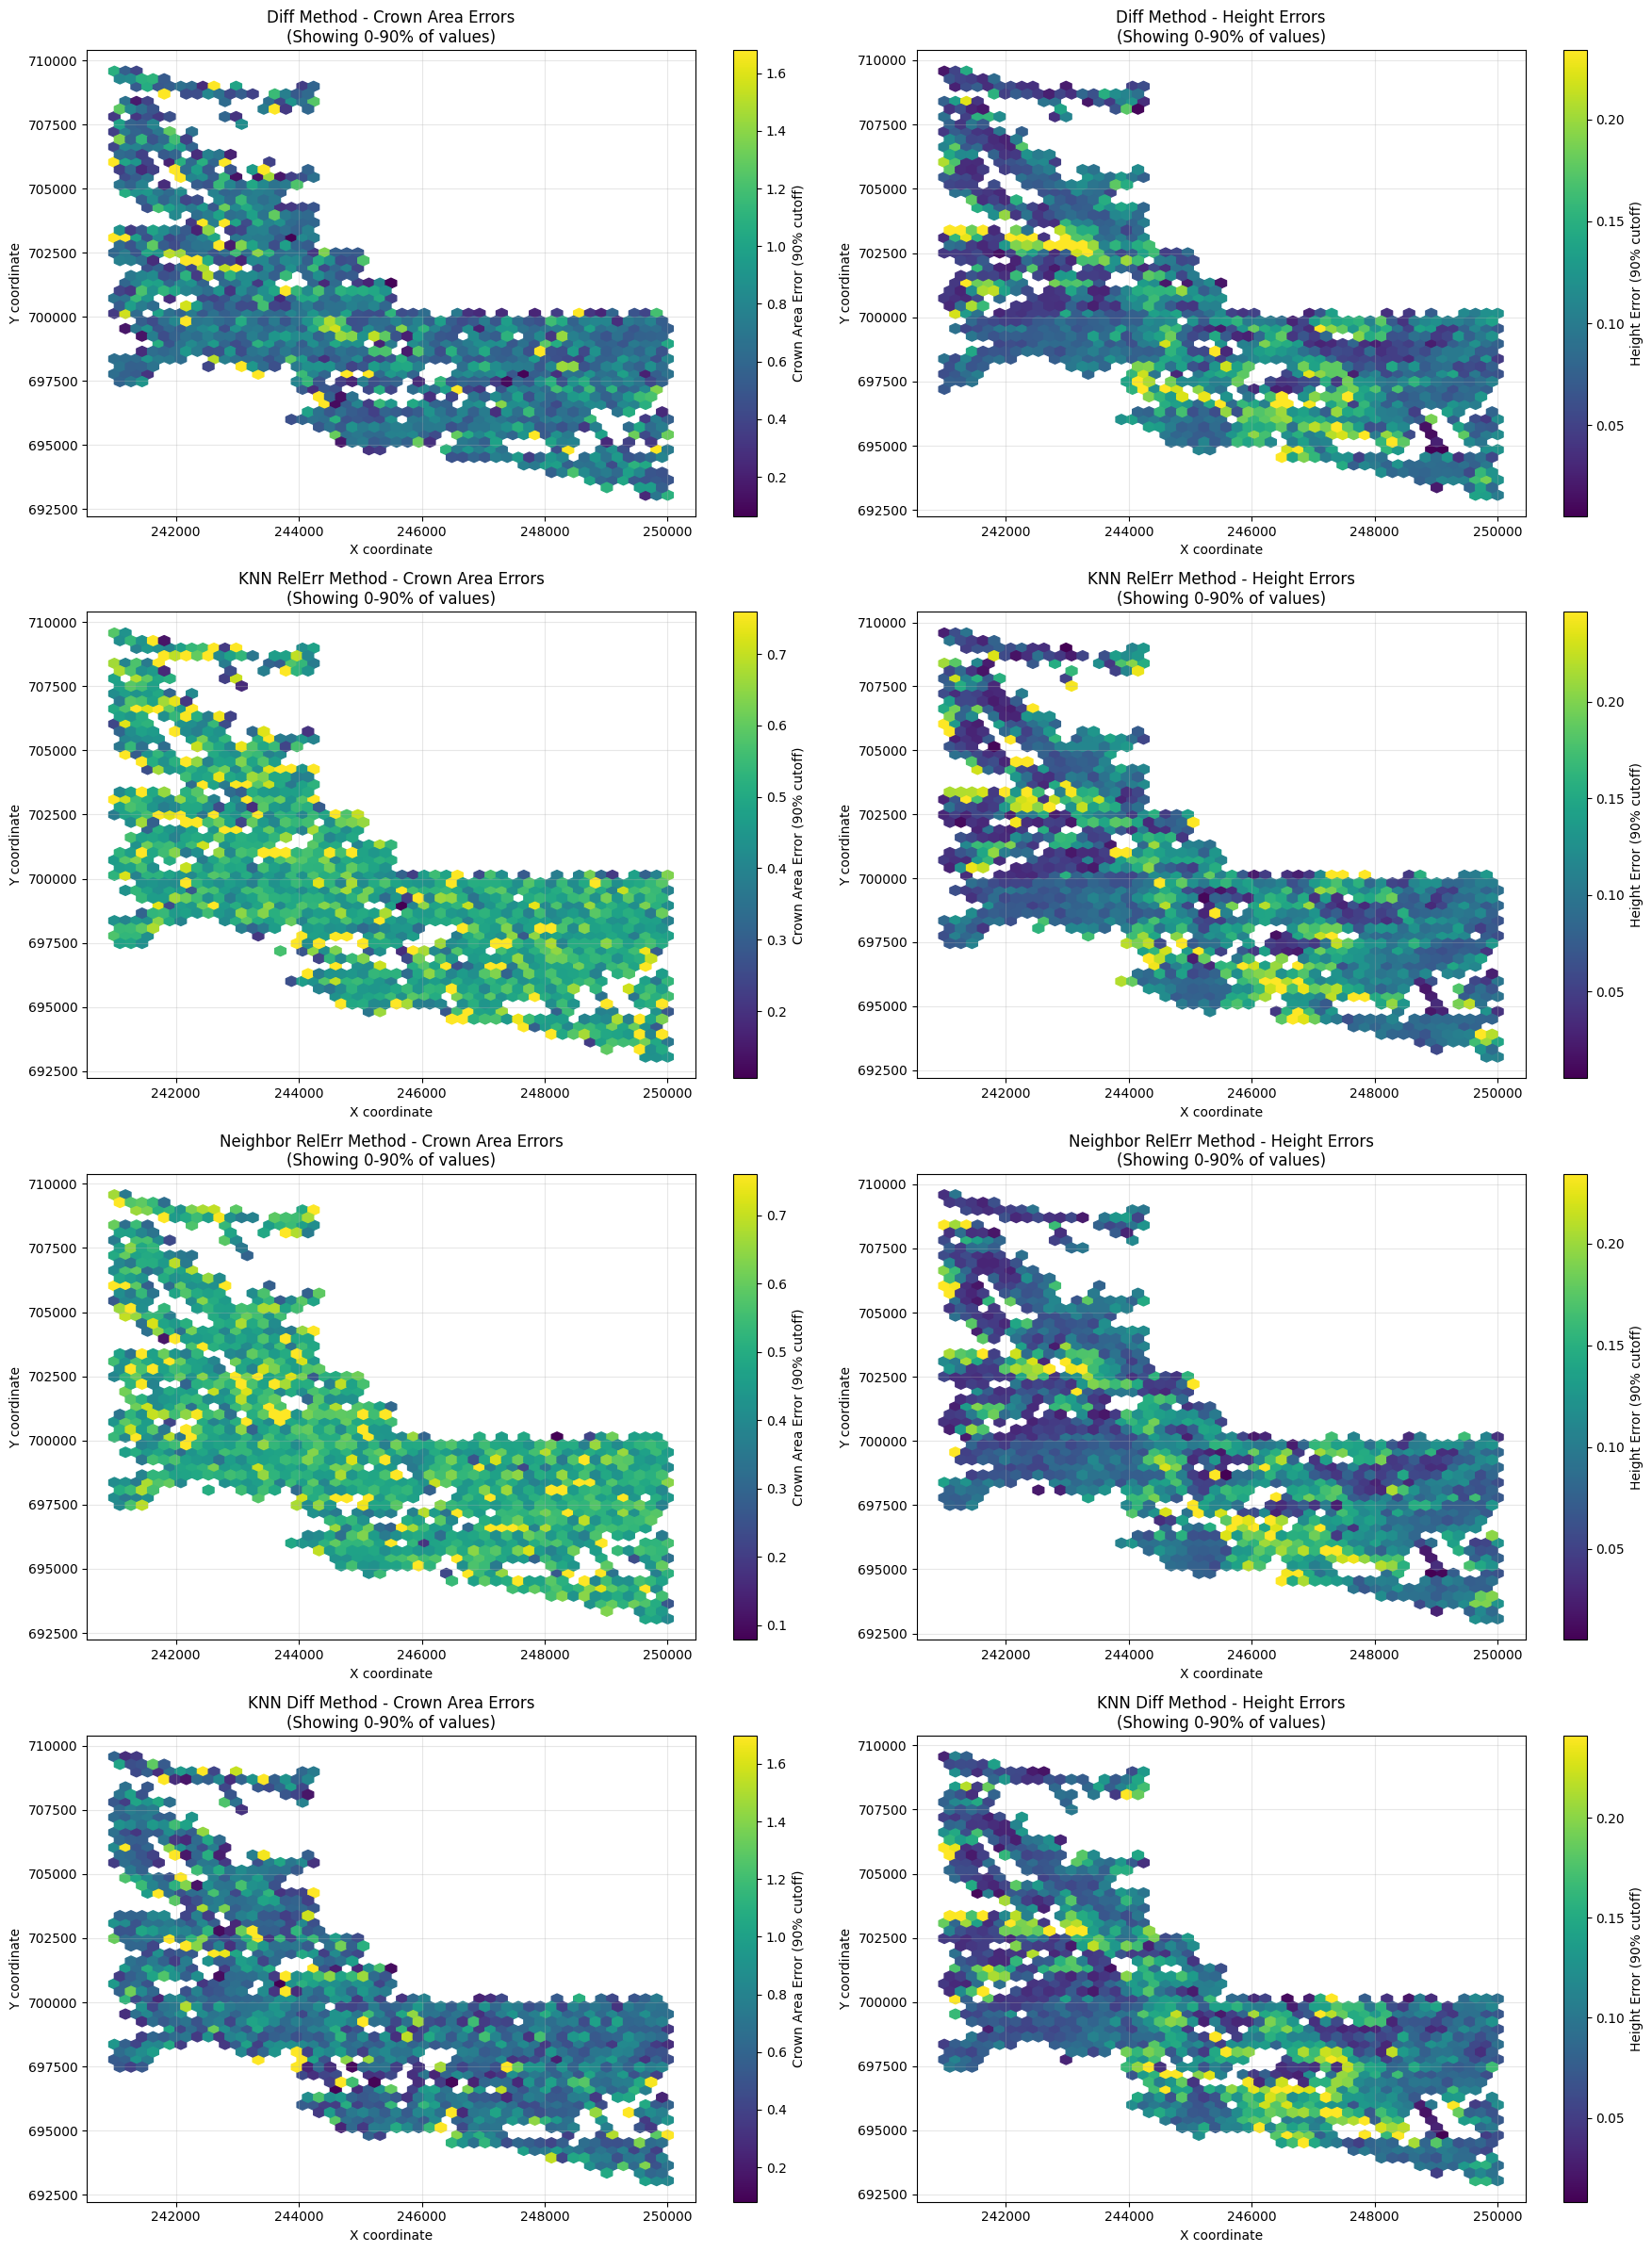

90th percentile cutoff values:
Differential Crown: 1.68
Differential Height: 0.23
KNN RelErr Crown: 0.76
KNN RelErr Height: 0.25
Neighbor RelErr Crown: 0.76
Neighbor RelErr Height: 0.23
KNN Diff Crown: 1.70
KNN Diff Height: 0.24


In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure (now 4 rows x 2 columns)
plt.figure(figsize=(18, 24))  # Increased height to accommodate extra row

# Common parameters
gridsize = 50
mincnt = 1
cmap = 'viridis'  # Consider 'plasma' or 'inferno' for better contrast
percentile_cutoff = 90  # We'll show up to this percentile of values

# Function to calculate vmax for each dataset
def get_vmax(data, cutoff_percentile):
    return np.percentile(data, cutoff_percentile)

# 1. bestDiffCrownStats - Crown Area
vmax = get_vmax(bestDiffCrownStats['CrownAreaError'], percentile_cutoff)
plt.subplot(4, 2, 1)
hb = plt.hexbin(bestDiffCrownStats['x'], bestDiffCrownStats['y'], 
               C=bestDiffCrownStats['CrownAreaError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
cb = plt.colorbar(hb, label='Crown Area Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Diff Method - Crown Area Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 2. bestDiffHeightStats - Height
vmax = get_vmax(bestDiffHeightStats['HeightError'], percentile_cutoff)
plt.subplot(4, 2, 2)
hb = plt.hexbin(bestDiffHeightStats['x'], bestDiffHeightStats['y'], 
               C=bestDiffHeightStats['HeightError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Height Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Diff Method - Height Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 3. bestKNNCrownRelErr - Crown Area
vmax = get_vmax(bestKNNCrownRelErr['CrownAreaError'], percentile_cutoff)
plt.subplot(4, 2, 3)
hb = plt.hexbin(bestKNNCrownRelErr['x'], bestKNNCrownRelErr['y'], 
               C=bestKNNCrownRelErr['CrownAreaError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Crown Area Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'KNN Direct Method - Crown Area Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 4. bestKNNheightRelErr - Height
vmax = get_vmax(bestKNNheightRelErr['HeightError'], percentile_cutoff)
plt.subplot(4, 2, 4)
hb = plt.hexbin(bestKNNheightRelErr['x'], bestKNNheightRelErr['y'], 
               C=bestKNNheightRelErr['HeightError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Height Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'KNN Direct Method - Height Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 5. bestCrownStats - Crown Area
vmax = get_vmax(bestCrownStats['CrownAreaError'], percentile_cutoff)
plt.subplot(4, 2, 5)
hb = plt.hexbin(bestCrownStats['x'], bestCrownStats['y'], 
               C=bestCrownStats['CrownAreaError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Crown Area Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Neighbor Direct Method - Crown Area Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 6. bestHeightStats - Height
vmax = get_vmax(bestHeightStats['HeightError'], percentile_cutoff)
plt.subplot(4, 2, 6)
hb = plt.hexbin(bestHeightStats['x'], bestHeightStats['y'], 
               C=bestHeightStats['HeightError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Height Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Neighbor Direct Method - Height Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 7. bestKNNDiffCrownMSE - Crown Area
vmax = get_vmax(bestKNNDiffCrownMSE['CrownAreaError'], percentile_cutoff)
plt.subplot(4, 2, 7)
hb = plt.hexbin(bestKNNDiffCrownMSE['x'], bestKNNDiffCrownMSE['y'], 
               C=bestKNNDiffCrownMSE['CrownAreaError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Crown Area Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'KNN Diff Method - Crown Area Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

# 8. bestKNNDiffHeightMSE - Height
vmax = get_vmax(bestKNNDiffHeightMSE['HeightError'], percentile_cutoff)
plt.subplot(4, 2, 8)
hb = plt.hexbin(bestKNNDiffHeightMSE['x'], bestKNNDiffHeightMSE['y'], 
               C=bestKNNDiffHeightMSE['HeightError'], 
               gridsize=gridsize, cmap=cmap, mincnt=mincnt,
               vmax=vmax)
plt.colorbar(hb, label=f'Height Error (90% cutoff)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'KNN Diff Method - Height Errors\n(Showing 0-{percentile_cutoff}% of values)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the cutoff values for reference (updated with new datasets)
print("90th percentile cutoff values:")
print(f"Differential Crown: {get_vmax(bestDiffCrownStats['CrownAreaError'], percentile_cutoff):.2f}")
print(f"Differential Height: {get_vmax(bestDiffHeightStats['HeightError'], percentile_cutoff):.2f}")
print(f"KNN RelErr Crown: {get_vmax(bestKNNCrownRelErr['CrownAreaError'], percentile_cutoff):.2f}")
print(f"KNN RelErr Height: {get_vmax(bestKNNheightRelErr['HeightError'], percentile_cutoff):.2f}")
print(f"Neighbor RelErr Crown: {get_vmax(bestCrownStats['CrownAreaError'], percentile_cutoff):.2f}")
print(f"Neighbor RelErr Height: {get_vmax(bestHeightStats['HeightError'], percentile_cutoff):.2f}")
print(f"KNN Diff Crown: {get_vmax(bestKNNDiffCrownMSE['CrownAreaError'], percentile_cutoff):.2f}")
print(f"KNN Diff Height: {get_vmax(bestKNNDiffHeightMSE['HeightError'], percentile_cutoff):.2f}")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


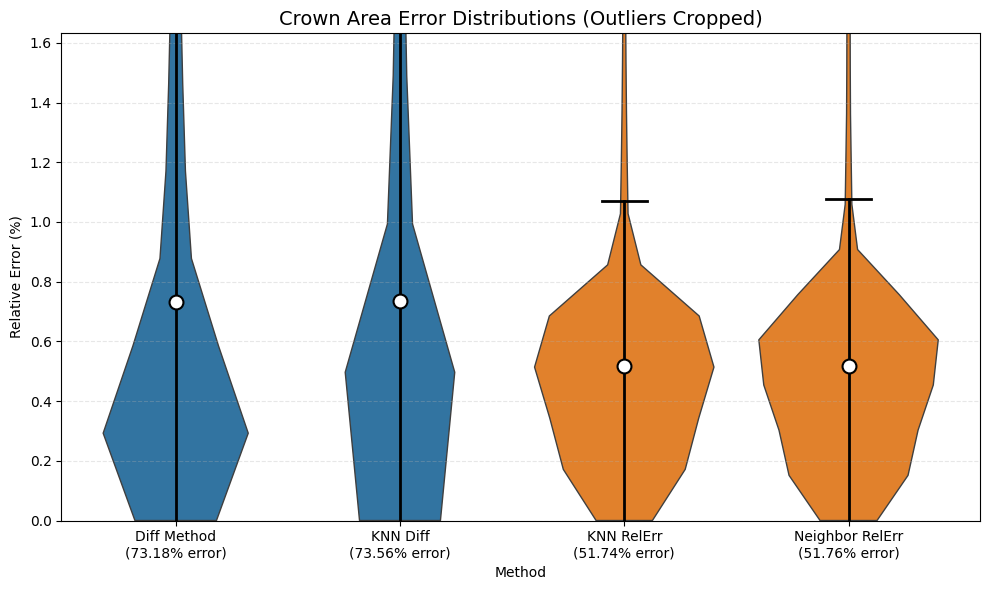

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


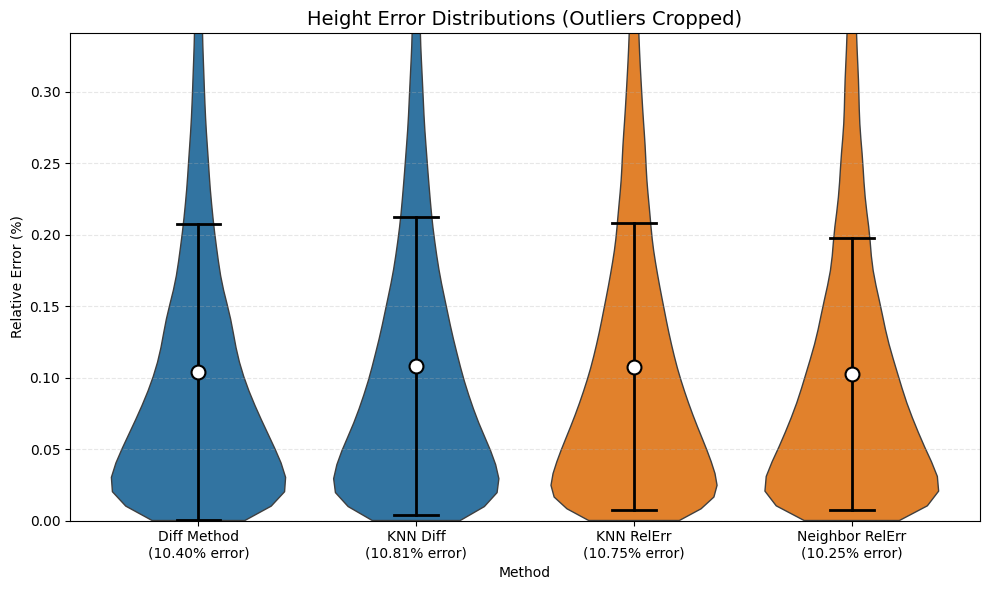

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ========================
# CROWN AREA ERROR PLOT
# ========================

plt.figure(figsize=(10, 6))

# Prepare crown data
crown_data_frames = {
    'DiffCrown': bestDiffCrownStats[['CrownAreaError']].rename(columns={'CrownAreaError': 'Error'}),
    'KNNCrownRelErr': bestKNNCrownRelErr[['CrownAreaError']].rename(columns={'CrownAreaError': 'Error'}),
    'CrownStats': bestCrownStats[['CrownAreaError']].rename(columns={'CrownAreaError': 'Error'}),
    'KNNDiffCrown': bestKNNDiffCrownMSE[['CrownAreaError']].rename(columns={'CrownAreaError': 'Error'})
}

all_crown_data = pd.concat(
    [df.assign(Method=method) for method, df in crown_data_frames.items()],
    ignore_index=True
)

# Calculate bounds for outlier cutoff
q1 = all_crown_data.groupby('Method')['Error'].quantile(0.25)
q3 = all_crown_data.groupby('Method')['Error'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
max_visible = max(upper_bound) * 1.05

# Colors and names
crown_palette = {
    'DiffCrown': '#1f77b4',
    'KNNCrownRelErr': '#ff7f0e',
    'CrownStats': '#ff7f0e',
    'KNNDiffCrown': '#1f77b4'
}

crown_display_names = {
    'DiffCrown': 'Diff Method\n(73.18% error)',
    'KNNCrownRelErr': 'KNN Direct Method\n(51.74% error)',
    'CrownStats': 'Neighbor Direct Method\n(51.76% error)',
    'KNNDiffCrown': 'KNN Diff\n(73.56% error)'
}

plot_order = ['DiffCrown', 'KNNDiffCrown', 'KNNCrownRelErr', 'CrownStats']

# Create plot
ax = sns.violinplot(x='Method', y='Error', data=all_crown_data,
                   order=plot_order,
                   palette=[crown_palette[method] for method in plot_order],
                   inner=None,
                   linewidth=1,
                   edgecolor='white',
                   cut=0)

ax.set_xticklabels([crown_display_names[method] for method in plot_order])

# Add mean markers
means = all_crown_data.groupby('Method')['Error'].mean()[plot_order].values
plt.scatter(x=np.arange(len(plot_order)),
            y=means,
            color='white',
            edgecolor='black',
            s=100,
            zorder=10,
            linewidths=1.5)

# Add error bars
stds = all_crown_data.groupby('Method')['Error'].std()[plot_order]
for i, (method, std) in enumerate(stds.items()):
    mean = means[i]
    plt.plot([i, i], [mean-std, mean+std], color='black', linewidth=2)
    plt.plot([i-0.1, i+0.1], [mean+std, mean+std], color='black', linewidth=2)
    plt.plot([i-0.1, i+0.1], [mean-std, mean-std], color='black', linewidth=2)

plt.ylim(0, max_visible)
plt.title('Crown Area Error Distributions (Outliers Cropped)', fontsize=14)
plt.ylabel('Relative Error (%)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ========================
# HEIGHT ERROR PLOT
# ========================

plt.figure(figsize=(10, 6))

# Prepare height data
height_data_frames = {
    'DiffHeight': bestDiffHeightStats[['HeightError']].rename(columns={'HeightError': 'Error'}),
    'KNNHeightRelErr': bestKNNheightRelErr[['HeightError']].rename(columns={'HeightError': 'Error'}),
    'HeightStats': bestHeightStats[['HeightError']].rename(columns={'HeightError': 'Error'}),
    'KNNDiffHeight': bestKNNDiffHeightMSE[['HeightError']].rename(columns={'HeightError': 'Error'})
}

all_height_data = pd.concat(
    [df.assign(Method=method) for method, df in height_data_frames.items()],
    ignore_index=True
)

# Calculate bounds for outlier cutoff
q1 = all_height_data.groupby('Method')['Error'].quantile(0.25)
q3 = all_height_data.groupby('Method')['Error'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
max_visible = max(upper_bound) * 1.05

# Colors and names
height_palette = {
    'DiffHeight': '#1f77b4',
    'KNNHeightRelErr': '#ff7f0e',
    'HeightStats': '#ff7f0e',
    'KNNDiffHeight': '#1f77b4'
}

height_display_names = {
    'DiffHeight': 'Diff Method\n(10.40% error)',
    'KNNHeightRelErr': 'KNN RelErr\n(10.75% error)',
    'HeightStats': 'Neighbor RelErr\n(10.25% error)',
    'KNNDiffHeight': 'KNN Diff\n(10.81% error)'
}

plot_order = ['DiffHeight', 'KNNDiffHeight', 'KNNHeightRelErr', 'HeightStats']

# Create plot
ax = sns.violinplot(x='Method', y='Error', data=all_height_data,
                   order=plot_order,
                   palette=[height_palette[method] for method in plot_order],
                   inner=None,
                   linewidth=1,
                   edgecolor='white',
                   cut=0)

ax.set_xticklabels([height_display_names[method] for method in plot_order])

# Add mean markers
means = all_height_data.groupby('Method')['Error'].mean()[plot_order].values
plt.scatter(x=np.arange(len(plot_order)),
            y=means,
            color='white',
            edgecolor='black',
            s=100,
            zorder=10,
            linewidths=1.5)

# Add error bars
stds = all_height_data.groupby('Method')['Error'].std()[plot_order]
for i, (method, std) in enumerate(stds.items()):
    mean = means[i]
    plt.plot([i, i], [mean-std, mean+std], color='black', linewidth=2)
    plt.plot([i-0.1, i+0.1], [mean+std, mean+std], color='black', linewidth=2)
    plt.plot([i-0.1, i+0.1], [mean-std, mean-std], color='black', linewidth=2)

plt.ylim(0, max_visible)
plt.title('Height Error Distributions (Outliers Cropped)', fontsize=14)
plt.ylabel('Relative Error (%)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
matchedYears = pd.read_csv("/kaggle/input/knnrepresentation/knn5-15Trees.csv")
scaler = StandardScaler()
matchedYears.columns


for col in matchedYears.columns:
    if isinstance(matchedYears[col].dtype, pd.SparseDtype):
        print(f"Column {col} is sparse!")

In [ ]:
matchedYears = matchedYears[(matchedYears["FutureZ"] != 0) & (matchedYears["FutureCrown"] > 1) & (matchedYears["CrownArea(square metre)"] > 1) & (matchedYears["FutureArea"] != 0)]

matchedYears["heightDiff"] = matchedYears["FutureZ"] - matchedYears["TreePosZ"]
matchedYears["crownDiaDiff"] = matchedYears["FutureCrown"] - matchedYears["CrownDiameter(metre)"]
matchedYears["crownAreaDiff"] = matchedYears["FutureArea"] - matchedYears["CrownArea(square metre)"]

matchedYears = matchedYears[matchedYears["heightDiff"] > -0.5]
#Assuming trees that are shorter over the year is mismatched

tCol = []
for col in matchedYears.columns:
    if "Norm" in col:
        tCol.append(col)
print(tCol)

In [ ]:
total = len(matchedYears)
split = math.floor(total * 0.8)

shuffled = matchedYears.sample(frac=1)

train = shuffled.iloc[:split]
test = shuffled.iloc[split:]


train_x = train[tCol]
test_x = test[tCol]


trainFutureZ = train["FutureZ"]
trainCrownArea = train["FutureArea"]

trainDiffZ = train["heightDiff"]
trainDiffArea = train["crownAreaDiff"]

testFutureZ = test["FutureZ"]
testCrownArea = test["FutureArea"]

testDiffZ = test["heightDiff"]
testDiffArea = test["crownAreaDiff"]


# One scaler per output
scaler_z = StandardScaler()
scaler_area = StandardScaler()
scaler_diffz = StandardScaler()
scaler_diffarea = StandardScaler()

# Fit on training data
trainFutureZNorm = scaler_z.fit_transform(trainFutureZ.values.reshape(-1, 1))
trainCrownAreaNorm = scaler_area.fit_transform(trainCrownArea.values.reshape(-1, 1))

trainDiffZNorm = scaler_diffz.fit_transform(trainDiffZ.values.reshape(-1, 1))
trainDiffAreaNorm = scaler_diffarea.fit_transform(trainDiffArea.values.reshape(-1, 1))

# Fit scalers on training data
trainDiffZNorm = scaler_diffz.fit_transform(trainDiffZ.values.reshape(-1, 1))
trainDiffAreaNorm = scaler_diffarea.fit_transform(trainDiffArea.values.reshape(-1, 1))

# Use the same scaler to transform test data
testFutureZNorm = scaler_z.transform(test["FutureZ"].values.reshape(-1, 1))
testCrownAreaNorm = scaler_area.transform(test["FutureArea"].values.reshape(-1, 1))

testDiffZNorm = scaler_diffz.transform(test["heightDiff"].values.reshape(-1, 1))
testDiffAreaNorm = scaler_diffarea.transform(test["crownAreaDiff"].values.reshape(-1, 1))

train.columns

In [ ]:
# Assign with correct shape from the beginning
selected_x_train = train_x.to_numpy()
selected_y_train = trainDiffZNorm # already (N, 1)

selected_x_test = test_x.to_numpy()
selected_y_test = testDiffZNorm # already (N, 1)

# height or crown
target = "height" 


# Try loading the model with custom_objects
model = load_model(
    "/kaggle/input/bestknnheightmse/funnelElu_height_diff_msemaxEpoch256relativeErrorHeight_10.81perc.h5",
    compile=False,
    custom_objects={"LeakyReLU": LeakyReLU}
)
errTable = pd.read_csv("/kaggle/input/bestknnheightmse/funnelElu_height_diff_msemaxEpoch256relativeErrorHeight_10.81perc.csv")

viewSet = 10
# Load the SHAP explainer
explainer = shap.Explainer(model, selected_x_train)

In [ ]:
# Compute SHAP values for a sample of validation data
shap_values = explainer(selected_x_train[:viewSet])  # Limit for efficiency

feature_names = tCol  

with open("bottleneckSHAP.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [ ]:
print("shap_values shape:", shap_values.shape)
print("selected_x_train shape:", selected_x_train[:viewSet].shape)

In [ ]:
shap.summary_plot(
    shap_values.values[:, :], 
    selected_x_train[:viewSet], 
    feature_names=feature_names  # Pass feature names here
)


In [ ]:
shap.summary_plot(
    shap_values.values, 
    selected_x_train[:viewSet], 
    feature_names=feature_names, 
    plot_type="bar",
)


In [ ]:
print(len(tCol))

In [ ]:


errTable.columns

In [ ]:
error_col = "HeightError" if target == "height" else "CrownAreaError"
true_col = "TrueHeight" if target == "height" else "TrueArea"


vmax = np.percentile(errTable[error_col], 95)

plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    errTable['x'], 
    errTable['y'], 
    C=errTable[error_col], 
    gridsize=50, 
    cmap='viridis', 
    reduce_C_function=np.mean,
    vmax=vmax  # Set color scale max at 95th percentile
)
plt.colorbar(hb, label='Mean Relative Error (capped at 95th percentile)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


In [ ]:
plt.hist2d(errTable[true_col], errTable[error_col], bins=50, cmap="viridis")

# Add a color bar to show the point density
plt.colorbar(label="Density")

# Label axes
plt.xlabel(true_col)
plt.ylabel(error_col)

# Show plot
plt.show()


In [ ]:
plt.scatter(errTable[true_col], errTable[error_col], alpha = 0.05)

In [ ]:
import seaborn as sns


# Determine the column names for the x and y values based on the target
true_col = "TrueHeight" if target == "height" else "TrueArea"
error_col = "HeightError" if target == "height" else "CrownAreaError"

# Plot the joint KDE plot to show density of points
sns.jointplot(x=true_col, y=error_col, data=errTable, kind="kde", cmap="Blues")

# Show plot
plt.show()